In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp
import time
import gc
import numpy as np
from scipy.stats import spearmanr
from datetime import timedelta


In [2]:
import random

In [3]:

# from sklearn.compose import ColumnTransformer
# from sklearn.datasets import fetch_openml
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import MinMaxScaler

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
import lightgbm as lgb

In [4]:
###reading in training set

train=pd.read_csv("training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [5]:
# dropping columns with high nulls

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff',
'date_time',
'prop_brand_bool',
'gross_bookings_usd',
'visitor_hist_starrating',
'visitor_hist_adr_usd',
'prop_log_historical_price',
'srch_query_affinity_score'
]



#creating dependant variabe 
conditions = [
    (train['booking_bool']> 0),
    (train['click_bool']> 0)
]

choices = [5 ,1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

#filtering out price outliers 
#train = train[train.price_usd < 3001]

In [6]:
    ## creating time related features
    
#train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce')

In [7]:
#more time related features

#train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
#train["srch_for_month"] = train["srch_for_date"].dt.month


In [8]:
#filling in missing values for prop_review_score and prop_starrating using average rating 
#based off similar priced hotels 
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star



In [9]:
#comparing price for hotels with other hotels in the same search

train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


train['mean_review_srch'] = train.groupby('srch_id')['prop_review_score'].transform('mean') 
train['diff_mean_review'] =  (train['prop_review_score'] - train['mean_review_srch']) / train['mean_review_srch']
train['mean_star_srch'] = train.groupby('srch_id')['prop_starrating'].transform('mean') 
train['diff_mean_star'] =  (train['prop_starrating'] - train['mean_star_srch']) / train['prop_starrating']
train['mean_location_score'] = train.groupby('srch_id')['prop_location_score1'].transform('mean') 
train['diff_location_score'] =  (train['prop_location_score1'] - train['mean_location_score']) / train['prop_location_score1'] 
train['mean_location2_score'] = train.groupby('srch_id')['prop_location_score2'].transform('mean')
median = train['prop_location_score2'].median()
train['median_location2_dest_score'] = train.groupby('srch_destination_id')['prop_location_score2'].transform('median') 
train.loc[train['prop_location_score2'].isnull(), "prop_location_score2"] = train['median_location2_dest_score']
train.loc[train['median_location2_dest_score'].isnull(), "median_location2_dest_score"] = 0.007
#train['prop_location_score2'] = train['prop_location_score2'].fillna(value=median, inplace=True )
#train['prop_location_score2'] = train['prop_location_score2'].fillna(0.07,inplace=True)
#train['prop_location_score2'] = train['prop_location_score2'].replace(np.nan, 0)

train['diff_location2_score'] =  (train['prop_location_score2'] - train['median_location2_dest_score']) / train['prop_location_score2']
train.loc[train['diff_location2_score'].isnull(), "'diff_location2_score"] = 0

train['median_orig_dest_distance'] = train.groupby('srch_id')['orig_destination_distance'].transform('median')
train['mean_orig_dest_distance'] = train.groupby('srch_id')['orig_destination_distance'].transform('mean')
train['diff_orig_dest_distance'] = train['orig_destination_distance'] - train['median_orig_dest_distance']
train['diff_orig_dest_distance1']=train['diff_orig_dest_distance'].abs()
train['rank_distance'] = train.groupby("srch_id")["diff_orig_dest_distance1"].rank("dense", ascending=True)
train.loc[train['rank_distance'].isnull(), 'rank_distance'] = random.choice([7,8,9,10,11,12])
train.loc[train['orig_destination_distance'].isnull(), 'orig_destination_distance'] = train['orig_destination_distance'].mean()


train['location_size'] = train.groupby('srch_destination_id')['prop_id'].transform('nunique')
train['location_%'] = train.groupby('srch_destination_id')['srch_id'].transform('nunique') /(train.srch_id.unique()).size

train['srch_results_count'] =  train.groupby('srch_id')['prop_id'].transform('count')
train['srch_%'] =  1/train['srch_results_count']

train['rank_distance_n'] =  train['rank_distance']/train['srch_results_count']

train['rank_price'] = train.groupby("srch_id")["price_usd"].rank("dense", ascending=True)
train['rank_price_n'] = train['rank_price']/train['srch_results_count']

train['rank_location'] = train.groupby("srch_id")["prop_location_score1"].rank("dense", ascending=False)
train['rank_location_n'] = train['rank_location']/train['srch_results_count']

train['rank_review'] = train.groupby("srch_id")["prop_review_score"].rank("dense", ascending=False)
train['rank_review_n'] = train['rank_review']/train['srch_results_count']

train['rank_star'] = train.groupby("srch_id")["prop_starrating"].rank("dense", ascending=False)
train['rank_star_n'] = train['rank_star']/train['srch_results_count']

train['prop_location_score2'] = train['prop_location_score2'].replace(np.nan, 0)

#train_reduced['"prop_location_score2'] = train_reduced['prop_location_score2'].replace(np.nan, 0)
train['rank_location2'] = train.groupby("srch_id")["prop_location_score2"].rank("dense", ascending=False)
train['rank_location2_n'] = train['rank_location2']/train['srch_results_count']

train['rank'] = train['rank_location2']  + train['rank_star'] + train['rank_price']
train['rank_n'] = train['rank_location2_n']  + train['rank_star_n'] + train['rank_price_n']

train['position_rank'] = train.groupby("srch_id")["position"].rank("dense", ascending=True)


In [10]:
train[['diff_location2_score', 'prop_location_score2','median_location2_dest_score']].isnull().mean() * 100

diff_location2_score           2.475099
prop_location_score2           0.000000
median_location2_dest_score    0.000000
dtype: float64

In [11]:
# getting actual click and booking statistics for each hotel & if there was a booking - how many adults,children,rooms

train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / (train.srch_id.unique()).size
train['show_feature']= train['location_%'] *train['hotel_show_prob']
    
train_calcs = train[train.booking_bool == 1]
train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean') 
train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean') 
train_calcs['hotel_avg_stay'] = train_calcs.groupby('prop_id')['srch_length_of_stay'].transform('mean') 
train_calcs['hotel_avg_room_count'] = train_calcs.groupby('prop_id')['srch_room_count'].transform('mean') 
train_calcs['bought'] = train_calcs.groupby('prop_id')['booking_bool'].transform('sum') 
train_calcs = train_calcs[['prop_id','hotel_avg_children', 'hotel_avg_adult', 'hotel_avg_stay','hotel_avg_room_count','bought']]

#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)
train_calcs = train_calcs.drop_duplicates(subset=['prop_id'])

train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_bought_bool'] = train['hotel_buy_prob'].apply(lambda x: 1 if x > 0 else 0)
train['hotel_click_bool'] = train['hotel_click_prob'].apply(lambda x: 1 if x > 0 else 0)
train['mean_position'] = train.groupby('prop_id')['position_rank'].transform('mean') 

hotel_click_stats = train[['prop_id', 'hotel_buy_prob','hotel_click_prob','hotel_bought_bool','hotel_click_bool','mean_position']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_9180\2107996377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_9180\2107996377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_9180\2107996377.py:9: SettingWith

In [12]:
train_reduced = train
### merging hotel specific cals to main dataset 
train_reduced = train_reduced.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')

train_reduced['srch_mean_avg_children'] =  train_reduced.groupby('srch_id')['hotel_avg_children'].transform('mean') 
train_reduced['srch_mean_avg_children'] = train_reduced['srch_mean_avg_children'].replace(np.nan,  0)
train_reduced['srch_mean_avg_adult'] =  train_reduced.groupby('srch_id')['hotel_avg_adult'].transform('mean')
train_reduced['srch_mean_avg_adult'] = train_reduced['srch_mean_avg_adult'].replace(np.nan,  0)
train_reduced['srch_mean_avg_stay'] =  train_reduced.groupby('srch_id')['hotel_avg_stay'].transform('mean')
train_reduced['srch_mean_avg_stay'] = train_reduced['srch_mean_avg_stay'].replace(np.nan,  0)
train_reduced['srch_mean_avg_room_count'] =  train_reduced.groupby('srch_id')['hotel_avg_room_count'].transform('mean')
train_reduced['srch_mean_avg_room_count'] = train_reduced['srch_mean_avg_room_count'].replace(np.nan,  0)


train_reduced.loc[train_reduced['hotel_avg_children'].isnull(), "hotel_avg_children"] = train_reduced['srch_mean_avg_children']
train_reduced.loc[train_reduced['hotel_avg_adult'].isnull(), "hotel_avg_adult"] = train_reduced['srch_mean_avg_adult']
train_reduced.loc[train_reduced['hotel_avg_stay'].isnull(), "hotel_avg_stay"] = train_reduced['srch_mean_avg_stay']
train_reduced.loc[train_reduced['hotel_avg_room_count'].isnull(), "hotel_avg_room_count"] = train_reduced['srch_mean_avg_room_count']

train_reduced['diff_avg_children'] = (train_reduced['srch_children_count'] - train_reduced['hotel_avg_children'])
train_reduced['diff_avg_adult'] = (train_reduced['srch_adults_count'] - train_reduced['hotel_avg_adult'])/train_reduced['srch_adults_count']
train_reduced['diff_avg_stay'] = (train_reduced['srch_length_of_stay'] - train_reduced['hotel_avg_stay'])/train_reduced['srch_length_of_stay']
train_reduced['diff_avg_room_count'] = (train_reduced['srch_room_count'] - train_reduced['hotel_avg_room_count'])/train_reduced['srch_room_count']

train_reduced['diff_avg_children1']=train_reduced['diff_avg_children'].abs()
train_reduced['diff_avg_adult1']=train_reduced['diff_avg_adult'].abs()
train_reduced['diff_avg_stay1']=train_reduced['diff_avg_stay'].abs()
train_reduced['diff_avg_room_count1']=train_reduced['diff_avg_room_count'].abs()

train_reduced['rank_child_match'] = train_reduced.groupby("srch_id")["diff_avg_children1"].rank("dense", ascending=True)
train_reduced['rank_child_match_n'] = train_reduced['rank_child_match']/train_reduced['srch_results_count']

train_reduced['rank_adult_match'] = train_reduced.groupby("srch_id")['diff_avg_adult1'].rank("dense", ascending=True)
train_reduced['rank_adult_match_n'] = train_reduced['rank_adult_match']/train_reduced['srch_results_count']

train_reduced['rank_stay_match'] = train_reduced.groupby("srch_id")['diff_avg_stay1'].rank("dense", ascending=True)
train_reduced['rank_stay_match_n'] = train_reduced['rank_stay_match']/train_reduced['srch_results_count']

train_reduced['rank_room_match'] = train_reduced.groupby("srch_id")['diff_avg_room_count1'].rank("dense", ascending=True)
train_reduced['rank_room_match_n'] = train_reduced['rank_room_match']/train_reduced['srch_results_count']

train_reduced['rank2'] = train_reduced['rank_child_match'] + train_reduced['rank_adult_match'] + train_reduced['rank_stay_match'] + train_reduced['rank_room_match']
train_reduced['rank2_n'] = train_reduced['rank_child_match_n'] + train_reduced['rank_adult_match_n'] + train_reduced['rank_stay_match_n'] + train_reduced['rank_room_match_n']

train_reduced['rank3'] = train_reduced['rank_distance'] + train_reduced['rank_price'] + train_reduced['rank_stay_match'] + train_reduced['rank_room_match']
train_reduced['rank3_n'] = train_reduced['rank_distance_n'] + train_reduced['rank_price_n'] + train_reduced['rank_stay_match_n'] + train_reduced['rank_room_match_n']

#train_reduced['estimated_position'] = train_reduced.groupby("prop_id")["position"].transform('mean')

#to_keep[['estimated_position','prop_id','hotel_click_bool','hotel_book_bool','location_clicks%','location_booking%']] = train_reduced[['estimated_position','prop_id','hotel_click_bool','hotel_book_bool','location_clicks%','location_booking%']]

In [13]:
del train

In [16]:
def normalize_features(input_df, group_key, target_column, take_log10=False):

    # for numerical stability
    epsilon = 1e-4
    if take_log10:
        input_df[target_column] = np.log10(input_df[target_column] + epsilon)
    methods = ["mean", "std"]

    df = input_df.groupby(group_key).agg({target_column: methods})

    df.columns = df.columns.droplevel()
    col = {}
    for method in methods:
        col[method] = target_column + "_" + method

    df.rename(columns=col, inplace=True)
    df_merge = input_df.merge(df.reset_index(), on=group_key)
    df_merge[target_column + "norm_by" + group_key] = (
        df_merge[target_column] - df_merge[target_column + "_mean"]
    ) / df_merge[target_column + "_std"]
    df_merge = df_merge.drop(labels=[col["mean"], col["std"]], axis=1)

    gc.collect()
    return df_merge


In [17]:

train_reduced = normalize_features(train_reduced,group_key="srch_id",target_column="price_usd",take_log10=True)
#train_reduced = normalize_features(train_reduced, group_key="prop_id", target_column="price_usd")
#train_reduced = normalize_features(train_reduced, group_key="srch_id", target_column="prop_starrating")

In [18]:
#dropped price bin
train_reduced = train_reduced.drop(['price_bin'], axis = 1)
#train_reduced.to_csv('hotel_calcs2.csv')

In [19]:
#del train1

NameError: name 'train1' is not defined

In [22]:
##droppping columns not needed 

# to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool',  'booking_bool', 'prop_location_score2'
#           ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought'] 

to_drop = ['site_id', 'visitor_location_country_id', 'prop_country_id',  'orig_destination_distance', 'click_bool',  'booking_bool', 'prop_location_score2'
          , 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought','position'] 



           
train1 = train_reduced.drop(to_drop,  axis=1)

#train1.to_csv('training_data.csv')


In [23]:
#train1=pd.read_csv('training_data.csv')

In [24]:
#train1.columns


In [25]:

##changing nan or null values to 0
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")

In [26]:
##ordering columns and selecting predictors + outcome
#train1 = train1[['srch_id', 'srch_destination_id', 'prop_id', 'prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value','rank_child_match','rank_adult_match','rank_stay_match','rank_room_match','random_bool','mean_review_srch','diff_mean_review','mean_star_srch','diff_mean_star','rank_price','rank_location','rank_review','rank_star','rank_location2','rank', 'position','rank_distance','rank2', 'rank3','location_size','outcome']]
train1 = train1[['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_location_score1', 'promotion_flag','price_usd',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'random_bool',  'diff_max_price',
       'diff_min_price', 'diff_mean_price', 'price_review_value',
       'mean_review_srch', 'diff_mean_review', 'mean_star_srch',
       'diff_mean_star', 'mean_location_score', 'median_location2_dest_score',
       'rank_distance', 'location_size', 'location_%', 'srch_results_count',
       'srch_%', 'rank_distance_n', 'rank_price', 'rank_price_n',
       'rank_location', 'rank_location_n', 'rank_review', 'rank_review_n',
       'rank_star', 'rank_star_n', 'rank_location2', 'rank_location2_n',
       'rank', 'rank_n', 'hotel_show_prob', 'show_feature',
       'hotel_buy_prob', 'hotel_click_prob', 'hotel_bought_bool',
       'hotel_click_bool', 'mean_position', 'hotel_avg_children',
       'hotel_avg_adult', 'hotel_avg_stay', 'hotel_avg_room_count',
       'srch_mean_avg_children', 'srch_mean_avg_adult', 'srch_mean_avg_stay',
       'srch_mean_avg_room_count', 'diff_avg_children', 'diff_avg_adult',
       'diff_avg_stay', 'diff_avg_room_count', 'diff_avg_children1',
       'diff_avg_adult1', 'diff_avg_stay1', 'diff_avg_room_count1',
       'rank_child_match', 'rank_child_match_n', 'rank_adult_match',
       'rank_adult_match_n', 'rank_stay_match', 'rank_stay_match_n',
       'rank_room_match', 'rank_room_match_n', 'rank2', 'rank2_n', 'rank3',
       'rank3_n', 'price_usdnorm_bysrch_id','outcome']]



In [27]:
#del train_reduced

In [28]:
from sklearn.model_selection import GroupShuffleSplit

def remove_columns(x1, ignore_column=["srch_id", "prop_id", "position", 'outcome']):
    ignore_column = [c for c in ignore_column if c in x1.columns.values]
    # print('Dropping columns: {}'.format(ignore_column))
    # ignore_column_numbers = [x1.columns.get_loc(x) for x in ignore_column]
    x1 = x1.drop(labels=ignore_column, axis=1)
    # print('Columns after dropping: {}'.format(x1.columns.values))
    return x1

def input_estimated_position(training_data, srch_id_dest_id_dict):
    training_data = training_data.merge(
        srch_id_dest_id_dict, how="left", on=["srch_destination_id", "prop_id"]
    )
    print(training_data.head())
    return training_data


def split_train_data(data_for_training):
    
    gss = GroupShuffleSplit(test_size=.6, n_splits=1, random_state = 7).split(data_for_training, groups=train1['srch_id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= data_for_training.iloc[X_train_inds]
    x1 = train_data.loc[:, ~train_data.columns.isin(['id','outcome'])]
    y1 = train_data.loc[:, train_data.columns.isin(['outcome'])]

    test_data= data_for_training.iloc[X_test_inds]

    #We need to keep the id for later predictions
    x2 = test_data.loc[:, ~test_data.columns.isin(['outcome'])]
    y2 = test_data.loc[:, test_data.columns.isin(['outcome'])]


    srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]

    # estimated position calculation
#     srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]
#     srch_id_dest_id_dict = x1.groupby(["srch_destination_id", "prop_id"]).agg(
#         {"position": "mean"}
#     )
#     srch_id_dest_id_dict = srch_id_dest_id_dict.rename(
#         index=str, columns={"position": "estimated_position"}
#     ).reset_index()
#     srch_id_dest_id_dict["srch_destination_id"] = (
#         srch_id_dest_id_dict["srch_destination_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["prop_id"] = (
#         srch_id_dest_id_dict["prop_id"].astype(str).astype(int)
#     )
#     srch_id_dest_id_dict["estimated_position"] = (
#         1 / srch_id_dest_id_dict["estimated_position"]
#     )
#     x1 = input_estimated_position(x1, srch_id_dest_id_dict)
#     x2 = input_estimated_position(x2, srch_id_dest_id_dict)

    groups = x1["srch_id"].value_counts(sort=False).sort_index()
    eval_groups = x2["srch_id"].value_counts(sort=False).sort_index()
    len(eval_groups), len(x2), len(x1), len(groups)

    x1 = remove_columns(x1)
    x2 = remove_columns(x2)
    return (x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict)

method = "dart"
lr = 0.12
x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict = split_train_data(train1)

In [29]:
%%time
name_of_model=None

if not name_of_model:
    name_of_model = str(int(time.time()))

clf = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    n_estimators=300,
    learning_rate=lr,
    max_position=5,
    label_gain=[0, 1,2,3,4,5, 6],
    random_state=69,
    seed=69,
    boosting=method,)
gc.collect()

print("Training on train set with columns: {}".format(x1.columns.values))
model = clf.fit(
    x1,
    y1,
    eval_set=[(x1, y1), (x2, y2)],
    eval_group=[groups, eval_groups],
    group=groups,
    eval_at=5,
    verbose=20,
    early_stopping_rounds=200,
    #categorical_feature=categorical_features_numbers,
)
    
print('done')
#print(model)
#gc.collect()
#pickle.dump(clf, open(os.path.join(output_dir, "model.dat"), "wb"))
#pickle.dump(model, open(os.path("model.dat", "wb")))



Training on train set with columns: ['prop_starrating' 'prop_review_score' 'prop_location_score1'
 'promotion_flag' 'price_usd' 'srch_destination_id' 'srch_length_of_stay'
 'srch_booking_window' 'srch_adults_count' 'srch_children_count'
 'srch_room_count' 'srch_saturday_night_bool' 'random_bool'
 'diff_max_price' 'diff_min_price' 'diff_mean_price' 'price_review_value'
 'mean_review_srch' 'diff_mean_review' 'mean_star_srch' 'diff_mean_star'
 'mean_location_score' 'median_location2_dest_score' 'rank_distance'
 'location_size' 'location_%' 'srch_results_count' 'srch_%'
 'rank_distance_n' 'rank_price' 'rank_price_n' 'rank_location'
 'rank_location_n' 'rank_review' 'rank_review_n' 'rank_star' 'rank_star_n'
 'rank_location2' 'rank_location2_n' 'rank' 'rank_n' 'hotel_show_prob'
 'show_feature' 'hotel_buy_prob' 'hotel_click_prob' 'hotel_bought_bool'
 'hotel_click_bool' 'mean_position' 'hotel_avg_children' 'hotel_avg_adult'
 'hotel_avg_stay' 'hotel_avg_room_count' 'srch_mean_avg_children'
 'src

C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] seed is set=69, random_state=69 will be ignored. Current value: seed=69


C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's ndcg@5: 0.510367	valid_1's ndcg@5: 0.50094
[40]	training's ndcg@5: 0.516243	valid_1's ndcg@5: 0.505416
[60]	training's ndcg@5: 0.523331	valid_1's ndcg@5: 0.510512
[80]	training's ndcg@5: 0.525559	valid_1's ndcg@5: 0.512125
[100]	training's ndcg@5: 0.532763	valid_1's ndcg@5: 0.516953
[120]	training's ndcg@5: 0.539229	valid_1's ndcg@5: 0.521609
[140]	training's ndcg@5: 0.541683	valid_1's ndcg@5: 0.522754
[160]	training's ndcg@5: 0.543988	valid_1's ndcg@5: 0.524081
[180]	training's ndcg@5: 0.545335	valid_1's ndcg@5: 0.524605
[200]	training's ndcg@5: 0.547351	valid_1's ndcg@5: 0.526414
[220]	training's ndcg@5: 0.549631	valid_1's ndcg@5: 0.527285
[240]	training's ndcg@5: 0.552303	valid_1's ndcg@5: 0.528994
[260]	training's ndcg@5: 0.553985	valid_1's ndcg@5: 0.529883
[280]	training's ndcg@5: 0.555153	valid_1's ndcg@5: 0.530061
[300]	training's ndcg@5: 0.556827	valid_1's ndcg@5: 0.530449
done
CPU times: total: 1h 2min 42s
Wall time: 9min 13s


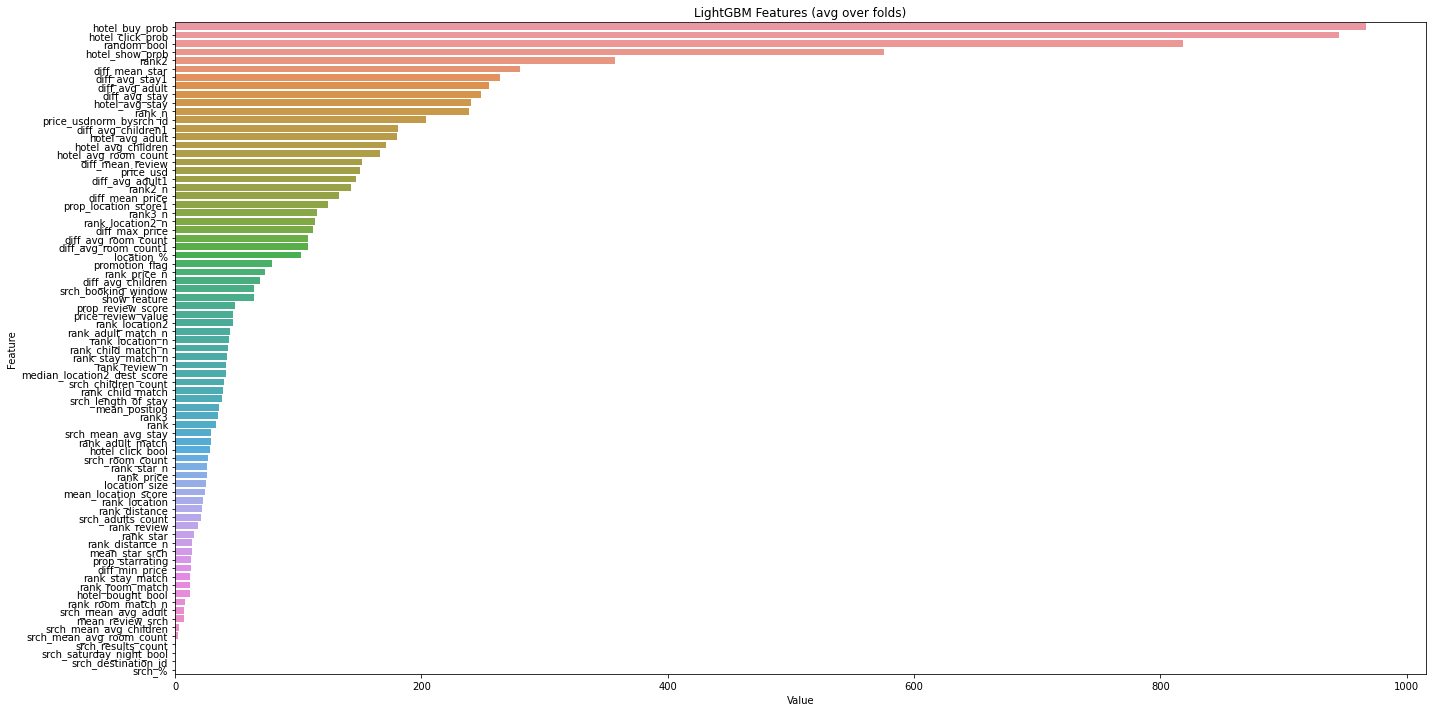

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x2.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [31]:
# # writing the results to a dataframe to analyse seperatly if needed ( ie how many false negatives, check values ect)

# result = pd.DataFrame(y1, columns=['actual'])
# predicted= pd.DataFrame(y2, columns=['predicted'])

# df = pd.DataFrame(X_test)
# df['result'] = result
# df['perdicted'] = predicted
# df.to_csv('results2.csv')
# df.head()

In [32]:
###################### pred 
del x1,y1,x2,y2


In [33]:
del train1

In [34]:
#### import competition dataset 

to_pred=pd.read_csv("test_set_VU_DM.csv")

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff',
'date_time',
'prop_brand_bool',
'visitor_hist_starrating',
'visitor_hist_adr_usd',
'prop_log_historical_price',
'srch_query_affinity_score'
]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )



to_pred = to_pred.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)


In [37]:
# creating same features as test data

#to_pred['date_time'] = pd.to_datetime(to_pred['date_time'], errors='coerce')

##################

# to_pred['srch_for_date'] = to_pred['date_time']  + pd.to_timedelta(to_pred['srch_booking_window'], unit='D')
# to_pred["srch_for_month"] = to_pred["srch_for_date"].dt.month

#train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
#train["srch_for_month"] = train["srch_for_date"].dt.month

####################

to_pred['price_bin'] = pd.qcut(to_pred['price_usd'], q=80, precision=0)
to_pred['mean_price_bin_star'] = to_pred.groupby('price_bin')['prop_starrating'].transform('mean')
to_pred['mean_price_bin_review'] = to_pred.groupby('price_bin')['prop_review_score'].transform('mean')
to_pred['prop_review_score'] = to_pred['prop_review_score'].fillna(0)
to_pred.loc[to_pred.prop_review_score == 0, "prop_review_score"] = to_pred.mean_price_bin_review
to_pred.loc[to_pred.prop_starrating == 0, "prop_starrating"] = to_pred.mean_price_bin_star

#############
to_pred = normalize_features(to_pred,group_key="srch_id",target_column="price_usd",take_log10=True,)
##################

to_pred['max_price'] = to_pred.groupby('srch_id')['price_usd'].transform('max') 
to_pred['min_price'] = to_pred.groupby('srch_id')['price_usd'].transform('min') 
to_pred['mean_price'] = to_pred.groupby('srch_id')['price_usd'].transform('mean') 
to_pred['diff_max_price'] =(to_pred['max_price'] -to_pred['price_usd']) / to_pred['price_usd']
to_pred['diff_min_price'] = (to_pred['min_price'] - to_pred['price_usd'])/ to_pred['price_usd']
to_pred['diff_min_price'] = to_pred['diff_min_price'].replace(np.nan, 0)
to_pred['diff_mean_price'] = (to_pred['mean_price'] - to_pred['price_usd']) / to_pred['price_usd']
to_pred['price_review_value'] =  to_pred['prop_review_score'] /to_pred['mean_price_bin_review'] 


to_pred['mean_review_srch'] = to_pred.groupby('srch_id')['prop_review_score'].transform('mean') 
to_pred['diff_mean_review'] =  (to_pred['prop_review_score'] - to_pred['mean_review_srch']) / to_pred['mean_review_srch']
to_pred['mean_star_srch'] = to_pred.groupby('srch_id')['prop_starrating'].transform('mean') 
to_pred['diff_mean_star'] =  (to_pred['prop_starrating'] - to_pred['mean_star_srch']) / to_pred['prop_starrating']
to_pred['mean_location_score'] = to_pred.groupby('srch_id')['prop_location_score1'].transform('mean') 
to_pred['diff_location_score'] =  (to_pred['prop_location_score1'] - to_pred['mean_location_score']) / to_pred['prop_location_score1']


to_pred['mean_location2_score'] = to_pred.groupby('srch_id')['prop_location_score2'].transform('mean')
median = to_pred['prop_location_score2'].median()
to_pred['median_location2_dest_score'] = to_pred.groupby('srch_destination_id')['prop_location_score2'].transform('median') 
to_pred.loc[to_pred['prop_location_score2'].isnull(), "prop_location_score2"] = to_pred['median_location2_dest_score']
to_pred.loc[to_pred['median_location2_dest_score'].isnull(), "median_location2_dest_score"] = 0.007
#train['prop_location_score2'] = train['prop_location_score2'].fillna(value=median, inplace=True )
#train['prop_location_score2'] = train['prop_location_score2'].fillna(0.07,inplace=True)
#train['prop_location_score2'] = train['prop_location_score2'].replace(np.nan, 0)

to_pred['diff_location2_score'] =  (to_pred['prop_location_score2'] - to_pred['median_location2_dest_score']) / to_pred['prop_location_score2']
to_pred.loc[to_pred['diff_location2_score'].isnull(), "'diff_location2_score"] = 0



to_pred['median_orig_dest_distance'] = to_pred.groupby('srch_id')['orig_destination_distance'].transform('median')
to_pred['mean_orig_dest_distance'] = to_pred.groupby('srch_id')['orig_destination_distance'].transform('mean')
to_pred['diff_orig_dest_distance'] = to_pred['orig_destination_distance'] - to_pred['median_orig_dest_distance']
to_pred['diff_orig_dest_distance1']=to_pred['diff_orig_dest_distance'].abs()
to_pred['rank_distance'] = to_pred.groupby("srch_id")["diff_orig_dest_distance1"].rank("dense", ascending=True)
to_pred.loc[to_pred['orig_destination_distance'].isnull(), 'orig_destination_distance'] = to_pred['orig_destination_distance'].mean()
to_pred.loc[to_pred['rank_distance'].isnull(), 'rank_distance'] = random.choice([7,8,9,10,11,12])



to_pred['location_size'] = to_pred.groupby('srch_destination_id')['prop_id'].transform('nunique')
to_pred['location_%'] = to_pred.groupby('srch_destination_id')['srch_id'].transform('nunique') /(to_pred.srch_id.unique()).size

to_pred['srch_results_count'] =  to_pred.groupby('srch_id')['prop_id'].transform('count')
to_pred['srch_%'] =  1/to_pred['srch_results_count']

to_pred['rank_distance_n'] =  to_pred['rank_distance']/to_pred['srch_results_count']

to_pred['rank_price'] = to_pred.groupby("srch_id")["price_usd"].rank("dense", ascending=True)
to_pred['rank_price_n'] = to_pred['rank_price']/to_pred['srch_results_count']

to_pred['rank_location'] = to_pred.groupby("srch_id")["prop_location_score1"].rank("dense", ascending=False)
to_pred['rank_location_n'] = to_pred['rank_location']/to_pred['srch_results_count']

to_pred['rank_review'] = to_pred.groupby("srch_id")["prop_review_score"].rank("dense", ascending=False)
to_pred['rank_review_n'] = to_pred['rank_review']/to_pred['srch_results_count']

to_pred['rank_star'] = to_pred.groupby("srch_id")["prop_starrating"].rank("dense", ascending=False)
to_pred['rank_star_n'] = to_pred['rank_star']/to_pred['srch_results_count']

to_pred['prop_location_score2'] = to_pred['prop_location_score2'].replace(np.nan, 0)

#train_reduced['"prop_location_score2'] = train_reduced['prop_location_score2'].replace(np.nan, 0)
to_pred['rank_location2'] = to_pred.groupby("srch_id")["prop_location_score2"].rank("dense", ascending=False)
to_pred['rank_location2_n'] = to_pred['rank_location2']/to_pred['srch_results_count']

to_pred['rank'] = to_pred['rank_location2']  + to_pred['rank_star'] + to_pred['rank_price']
to_pred['rank_n'] = to_pred['rank_location2_n']  + to_pred['rank_star_n'] + to_pred['rank_price_n']



#################

to_pred['hotel_show_prob'] =  to_pred.groupby('prop_id')['prop_id'].transform('count') / (to_pred.srch_id.unique()).size
to_pred['show_feature']= to_pred['location_%'] *to_pred['hotel_show_prob']

In [47]:
### mergeing hotel specific stats from test dataset 

to_pred_reduced = to_pred.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
hotel_click_stats = hotel_click_stats.drop_duplicates(subset=['prop_id'])
to_pred_reduced = to_pred_reduced.merge(hotel_click_stats, left_on=['prop_id'], right_on=['prop_id'], how='left')

In [48]:

# #to_pred_reduced .columns

# to_pred_reduced[['hotel_buy_prob', 'hotel_click_prob','hotel_bought_bool' ,'hotel_click_bool' ,'mean_position']].isnull().mean() * 100

In [49]:
to_pred_reduced['hotel_buy_prob'] = to_pred_reduced['hotel_buy_prob'].replace(np.nan,  0)
to_pred_reduced['hotel_click_prob'] = to_pred_reduced['hotel_click_prob'].replace(np.nan,  0)
to_pred_reduced['hotel_bought_bool'] = to_pred_reduced['hotel_bought_bool'].replace(np.nan, to_pred_reduced['hotel_bought_bool'].mean())
to_pred_reduced['hotel_click_bool'] = to_pred_reduced['hotel_click_bool'].replace(np.nan,  to_pred_reduced['hotel_click_bool'].mean())
#to_pred_reduced['mean_position'] = to_pred_reduced['mean_position'].replace(np.nan,  random.choice([7,8,9,10,11,12,13,14,15,16]))

In [50]:


#train_reduced = train_reduced.merge(train_clacs, on='prop_id', how='right', suffixes=('_1', '_2'))
#to_pred_reduced  = pd.concat([to_pred_reduced.set_index('prop_id'),train_calcs.set_index('prop_id')], axis=1, join='outer').reset_index()
#to_pred_reduced2  = pd.concat([to_pred_reduced.set_index('prop_id'),hotel_click_stats.set_index('prop_id')], axis=1, join='outer').reset_index()
to_pred_reduced .loc[to_pred_reduced['mean_position'].isnull(), 'mean_position'] = random.choice([10,11,12,13,14,15,16,17,18,19,20])


to_pred_reduced['srch_mean_avg_children'] =  to_pred_reduced.groupby('srch_id')['hotel_avg_children'].transform('mean') 
to_pred_reduced['srch_mean_avg_children'] = to_pred_reduced['srch_mean_avg_children'].replace(np.nan,  0)
to_pred_reduced['srch_mean_avg_adult'] =  to_pred_reduced.groupby('srch_id')['hotel_avg_adult'].transform('mean')
to_pred_reduced['srch_mean_avg_adult'] = to_pred_reduced['srch_mean_avg_adult'].replace(np.nan,  0)
to_pred_reduced['srch_mean_avg_stay'] =  to_pred_reduced.groupby('srch_id')['hotel_avg_stay'].transform('mean')
to_pred_reduced['srch_mean_avg_stay'] = to_pred_reduced['srch_mean_avg_stay'].replace(np.nan,  0)
to_pred_reduced['srch_mean_avg_room_count'] =  to_pred_reduced.groupby('srch_id')['hotel_avg_room_count'].transform('mean')
to_pred_reduced['srch_mean_avg_room_count'] = to_pred_reduced['srch_mean_avg_room_count'].replace(np.nan,  0)


to_pred_reduced.loc[to_pred_reduced['hotel_avg_children'].isnull(), "hotel_avg_children"] = to_pred_reduced['srch_mean_avg_children']
to_pred_reduced.loc[to_pred_reduced['hotel_avg_adult'].isnull(), "hotel_avg_adult"] = to_pred_reduced['srch_mean_avg_adult']
to_pred_reduced.loc[to_pred_reduced['hotel_avg_stay'].isnull(), "hotel_avg_stay"] = to_pred_reduced['srch_mean_avg_stay']
to_pred_reduced.loc[to_pred_reduced['hotel_avg_room_count'].isnull(), "hotel_avg_room_count"] = to_pred_reduced['srch_mean_avg_room_count']

to_pred_reduced['diff_avg_children'] = (to_pred_reduced['srch_children_count'] - to_pred_reduced['hotel_avg_children'])
to_pred_reduced['diff_avg_adult'] = (to_pred_reduced['srch_adults_count'] - to_pred_reduced['hotel_avg_adult'])/to_pred_reduced['srch_adults_count']
to_pred_reduced['diff_avg_stay'] = (to_pred_reduced['srch_length_of_stay'] - to_pred_reduced['hotel_avg_stay'])/to_pred_reduced['srch_length_of_stay']
to_pred_reduced['diff_avg_room_count'] = (to_pred_reduced['srch_room_count'] - to_pred_reduced['hotel_avg_room_count'])/to_pred_reduced['srch_room_count']

to_pred_reduced['diff_avg_children1']=to_pred_reduced['diff_avg_children'].abs()
to_pred_reduced['diff_avg_adult1']=to_pred_reduced['diff_avg_adult'].abs()
to_pred_reduced['diff_avg_stay1']=to_pred_reduced['diff_avg_stay'].abs()
to_pred_reduced['diff_avg_room_count1']=to_pred_reduced['diff_avg_room_count'].abs()

to_pred_reduced['rank_child_match'] = to_pred_reduced.groupby("srch_id")["diff_avg_children1"].rank("dense", ascending=True)
to_pred_reduced['rank_adult_match'] = to_pred_reduced.groupby("srch_id")['diff_avg_adult1'].rank("dense", ascending=True)
to_pred_reduced['rank_stay_match'] = to_pred_reduced.groupby("srch_id")['diff_avg_stay1'].rank("dense", ascending=True)
to_pred_reduced['rank_room_match'] = to_pred_reduced.groupby("srch_id")['diff_avg_room_count1'].rank("dense", ascending=True)


to_pred_reduced['rank_child_match_n'] = to_pred_reduced['rank_child_match']/to_pred_reduced['srch_results_count']
to_pred_reduced['rank_adult_match_n'] = to_pred_reduced['rank_adult_match']/to_pred_reduced['srch_results_count']
to_pred_reduced['rank_stay_match_n'] = to_pred_reduced['rank_stay_match']/to_pred_reduced['srch_results_count']
to_pred_reduced['rank_room_match_n'] = to_pred_reduced['rank_room_match']/to_pred_reduced['srch_results_count']
to_pred_reduced['rank2_n'] = to_pred_reduced['rank_child_match_n'] + to_pred_reduced['rank_adult_match_n'] + to_pred_reduced['rank_stay_match_n'] + to_pred_reduced['rank_room_match_n']

to_pred_reduced['rank3_n'] = to_pred_reduced['rank_distance_n'] + to_pred_reduced['rank_price_n'] + to_pred_reduced['rank_stay_match_n'] + to_pred_reduced['rank_room_match_n']
#to_pred_reduced['estimated_position'] = to_pred_reduced.groupby("prop_id")["position"].transform('mean')

to_pred_reduced['rank2'] = to_pred_reduced['rank_child_match'] + to_pred_reduced['rank_adult_match'] + to_pred_reduced['rank_stay_match'] + to_pred_reduced['rank_room_match']
to_pred_reduced['rank3'] = to_pred_reduced['rank_distance'] + to_pred_reduced['rank_price'] + to_pred_reduced['rank_stay_match'] + to_pred_reduced['rank_room_match']

#to_pred_reduced['estimated_position'] = to_pred_reduced.groupby("prop_id")["position"].transform('mean')



In [54]:
#to_pred_reduced[['price_usd', 'price_usdnorm_bysrch_id']].isnull().mean() * 100

price_usd                  0.0
price_usdnorm_bysrch_id    0.0
dtype: float64

In [53]:
to_pred_reduced['price_usd'] = to_pred_reduced['price_usd'].fillna(0)
to_pred_reduced['price_usdnorm_bysrch_id'] = to_pred_reduced['price_usdnorm_bysrch_id'].fillna(0)

In [42]:
to_pred_reduced = normalize_features(to_pred_reduced,group_key="srch_id",target_column="price_usd",take_log10=True,)

C:\Users\Admin\Documents\Masters College\datamining\assignment2\.venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
###droppping unused columns 
#del hotel_click_stats
#del to_pred

# to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id','price_bin', 'prop_brand_bool', 'orig_destination_distance', 'prop_location_score2'
#           ,'price_bin', 'max_price', 'srch_query_affinity_score','visitor_hist_starrating', 'visitor_hist_adr_usd', 'min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought'] 



to_drop = ['site_id', 'visitor_location_country_id', 'prop_country_id',  'orig_destination_distance', 'prop_location_score2'
          , 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star'] 






#del to_pred_reduced[ 'visitor_hist_adr_usd']

#to_drop = ['min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought',  'weekday', 'week_of_year', 'hour', 'time_epoch', 'month']
to_pred1= to_pred_reduced.drop(to_drop,  axis=1)

In [56]:

#del to_pred_reduced


In [57]:
#replacing nulls and nans

to_pred1.replace([np.inf, -np.inf], 0, inplace=True)

#to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']] = to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']].replace(np.nan, 0)

to_pred1=to_pred1.dropna(axis=1,how="any")
#msn.bar(to_pred1,figsize=(18,3), color='red')

In [58]:
##ordering df and selecting predictors
#to_pred1 = to_pred1[['srch_id', 'srch_destination_id', 'prop_id','prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value','rank_child_match','rank_adult_match','rank_stay_match','rank_room_match','mean_review_srch','diff_mean_review','mean_star_srch','diff_mean_star','rank_price','rank_location','rank_review','rank_star','rank_location2','rank','rank_distance','rank2', 'rank3','location_size','random_bool']]
to_pred1 = to_pred1[['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_location_score1', 'promotion_flag','price_usd',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'random_bool', 'diff_max_price',
       'diff_min_price', 'diff_mean_price', 'price_review_value',
       'mean_review_srch', 'diff_mean_review', 'mean_star_srch',
       'diff_mean_star', 'mean_location_score', 'median_location2_dest_score',
       'rank_distance', 'location_size', 'location_%', 'srch_results_count',
       'srch_%', 'rank_distance_n', 'rank_price', 'rank_price_n',
       'rank_location', 'rank_location_n', 'rank_review', 'rank_review_n',
       'rank_star', 'rank_star_n', 'rank_location2', 'rank_location2_n',
       'rank', 'rank_n', 'hotel_show_prob', 'show_feature',
       'hotel_buy_prob', 'hotel_click_prob', 'hotel_bought_bool',
       'hotel_click_bool', 'mean_position', 'hotel_avg_children',
       'hotel_avg_adult', 'hotel_avg_stay', 'hotel_avg_room_count',
       'srch_mean_avg_children', 'srch_mean_avg_adult', 'srch_mean_avg_stay',
       'srch_mean_avg_room_count', 'diff_avg_children', 'diff_avg_adult',
       'diff_avg_stay', 'diff_avg_room_count', 'diff_avg_children1',
       'diff_avg_adult1', 'diff_avg_stay1', 'diff_avg_room_count1',
       'rank_child_match', 'rank_child_match_n', 'rank_adult_match',
       'rank_adult_match_n', 'rank_stay_match', 'rank_stay_match_n',
       'rank_room_match', 'rank_room_match_n', 'rank2', 'rank2_n', 'rank3',
       'rank3_n', 'price_usdnorm_bysrch_id']]
#to_pred1 = to_pred1[['srch_destination_id', 'prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

In [ ]:


#gc.collect()

#model = pickle.load(open(os.path.join(output_dir, "model.dat"), "rb"))

#test_data = test_data.copy()
#test_data = input_estimated_position(test_data, srch_id_dest_id_dict)

test_data_srch_id_prop_id = to_pred1[["srch_id", "prop_id"]]

to_pred1 = to_pred1.drop(['prop_id', "srch_id" ],axis =1)
#test_data = remove_columns(test_data)

#categorical_features_numbers = get_categorical_column(test_data)

print("Predicting on train set with columns: {}".format(to_pred1.columns.values))
#kwargs = {}
#kwargs = {"categorical_feature": categorical_features_numbers}

predictions = model.predict(to_pred1)
test_data_srch_id_prop_id["prediction"] = predictions
del to_pred1
#gc.collect()


Predicting on train set with columns: ['prop_starrating' 'prop_review_score' 'prop_location_score1'
 'promotion_flag' 'price_usd' 'srch_destination_id' 'srch_length_of_stay'
 'srch_booking_window' 'srch_adults_count' 'srch_children_count'
 'srch_room_count' 'srch_saturday_night_bool' 'random_bool'
 'diff_max_price' 'diff_min_price' 'diff_mean_price' 'price_review_value'
 'mean_review_srch' 'diff_mean_review' 'mean_star_srch' 'diff_mean_star'
 'mean_location_score' 'median_location2_dest_score' 'rank_distance'
 'location_size' 'location_%' 'srch_results_count' 'srch_%'
 'rank_distance_n' 'rank_price' 'rank_price_n' 'rank_location'
 'rank_location_n' 'rank_review' 'rank_review_n' 'rank_star' 'rank_star_n'
 'rank_location2' 'rank_location2_n' 'rank' 'rank_n' 'hotel_show_prob'
 'show_feature' 'hotel_buy_prob' 'hotel_click_prob' 'hotel_bought_bool'
 'hotel_click_bool' 'mean_position' 'hotel_avg_children' 'hotel_avg_adult'
 'hotel_avg_stay' 'hotel_avg_room_count' 'srch_mean_avg_children'
 's

In [ ]:
test_data_srch_id_prop_id = test_data_srch_id_prop_id.sort_values(['srch_id', 'prediction'],ascending = [True, False])
test_data_srch_id_prop_id1 = test_data_srch_id_prop_id.drop(['prediction'], axis = 1)
test_data_srch_id_prop_id1.to_csv('submission.csv', index=False)

test_data_srch_id_prop_id1.head(5)

In [ ]:
# ## saving serch_id and prod_id for use in submission file 

# ids = to_pred1[['srch_id', 'prop_id']]

# to_drop = ['srch_id','prop_id']

# to_pred1 = to_pred1.drop(to_drop,  axis=1)

# ###### perdicitng outcome using model

# y_pred=l[1][0].predict(to_pred1)

# print(y_pred)

# y_pred[:5]

In [ ]:

# ###creating submission file

# predicted= pd.DataFrame(y_pred, columns=['predicted'])

# df = pd.DataFrame(to_pred1)

# df['perdicted'] = predicted

# df[['srch_id', 'prop_id']] = ids[['srch_id', 'prop_id']]

# df = df[['srch_id', 'prop_id', 'perdicted','hotel_buy_prob']]

# ##ordering submission file 


# df = df.sort_values(['srch_id', 'perdicted', 'hotel_buy_prob'],
#               ascending = [True, False,False])
# df = df.drop(['perdicted', 'hotel_buy_prob'], axis = 1)
# df.to_csv('submission.csv', index=False)

# df.head(5)